## Load joint info from csv file

In [1]:
## load joint info

import pandas as pd 


JOINT_CSV_FILENAME = '/var/data/MET2/activity.csv'
IMG_PATH_PREFIX = '/var/data/MET2/'

numJoints = 14
# prepare column names 
colNames = list()
colNames.append('ID')
for n in range(numJoints):
    colNames.append("x{}".format(n+1))
    colNames.append("y{}".format(n+1))    
for n in range(numJoints):
    colNames.append("v{}".format(n+1))
#print(colNames)

# load csv file
MET2_joints=pd.read_csv(JOINT_CSV_FILENAME,header=None,names=colNames) #,index_col=0)
MET2_joints.head()

,ID,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14
0,image/office activities/walking about/1.png,113,172,113,147,137,117,119,117,123,...,0,0,0,0,0,0,0,0,0,0
1,image/office activities/walking about/10.png,187,196,184,159,177,115,205,110,203,...,0,0,0,0,0,0,0,0,0,0
2,image/office activities/walking about/11.jpg,73,294,73,227,66,160,79,153,96,...,0,0,0,0,0,1,1,1,0,0
3,image/office activities/walking about/12.jpg,196,188,200,145,198,104,170,100,176,...,0,0,0,0,0,0,0,0,0,0
4,image/office activities/walking about/13.jpg,102,189,86,136,131,110,131,118,131,...,0,0,0,1,1,0,0,0,0,0


In [2]:
# column names
MET2_joints.columns

Index(['ID', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6',
       'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9', 'x10', 'y10', 'x11', 'y11',
       'x12', 'y12', 'x13', 'y13', 'x14', 'y14', 'v1', 'v2', 'v3', 'v4', 'v5',
       'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14'],
      dtype='object')

In [3]:
# get info of a sample
import numpy as np

imageIdx = 1
imageFilename = IMG_PATH_PREFIX+MET2_joints.loc[imageIdx][0]
print(imageFilename)
joints = MET2_joints.loc[imageIdx][1:14*2+1]
joints = np.asarray(joints).reshape(-1,2)
print(joints)
joints_valid = MET2_joints.loc[imageIdx][numJoints*2+1:]
joints_valid = np.asarray(joints).astype(np.bool)
print(joints_valid)

/var/data/MET2/image/office activities/walking about/10.png
[[187 196]
 [184 159]
 [177 115]
 [205 110]
 [203 152]
 [196 182]
 [161 113]
 [163 91]
 [170 56]
 [212 56]
 [217 85]
 [217 113]
 [190 47]
 [189 25]]
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]


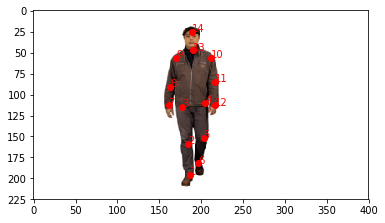

In [4]:
# plot image with true joints
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


def plotJoint(joints):
    # mark joint
    plt.plot(joints[:,0],joints[:,1], 'or')

    # add number
    numJoints, dim = joints.shape    
    for n in range(numJoints):
        plt.text(joints[n,0],joints[n,1], "{}".format(n+1), color=(1,0,0))
        

# load image
image = cv2.imread(imageFilename)
if image is None:
    print("Cannot load image.")
else:
    image.shape
    plt.imshow(image[:,:,::-1])
    plotJoint(joints)
    
    plt.show()
# 

## let's estimate joints!

In [5]:
# preprocess image to fit the model
# code from get_example in scripts/dataset.py
gcn=None
bbox_extension_range=None
shift=None


def calc_joints_bbox(joints):
    lt = np.min(joints, axis=0)
    rb = np.max(joints, axis=0)
    x, y = lt
    w = rb[0] - lt[0]
    h = rb[1] - lt[1]
    return x, y, w, h

bbox = calc_joints_bbox(joints)
print(bbox)

(161, 25, 56, 171)


In [6]:
## crop the image 
import math

def check_bounds(joints, x, y, w, h, exclude_upper_bound=False):
    """
    Function for a sanity check
    """
    eps = 1e-7

    assert joints[:, 0].max() <= x + w - exclude_upper_bound + eps, \
        'max={} > {}'.format(joints[:, 0].max(), x + w - exclude_upper_bound)
    assert joints[:, 1].max() <= y + h - exclude_upper_bound + eps, \
        'max={} > {}'.format(joints[:, 1].max(), y + h - exclude_upper_bound)
    assert joints[:, 0].min() >= x - eps, 'min={} < {}'.format(joints[:, 0].min(), x)
    assert joints[:, 1].min() >= y - eps, 'min={} < {}'.format(joints[:, 1].min(), y)
    
def apply_cropping(image, joints, bbox, bbox_extension_range=None, shift=None):
    """
    Randomly enlarge the bounding box of joints and randomly shift the box.
    Crop using the resultant bounding box.
    """
    x, y, w, h = bbox

    if bbox_extension_range is not None:
        if not (1.0 <= bbox_extension_range[0] <= bbox_extension_range[1]):
            raise ValueError('Must be 1.0 <= crop_pad_inf <= crop_pad_sup')
        # bounding rect extending
        inf, sup = bbox_extension_range
        r = sup - inf
        pad_w_r = np.random.rand() * r + inf  # inf~sup
        pad_h_r = np.random.rand() * r + inf  # inf~sup
        pad_x = (w * pad_w_r - w) / 2
        pad_y = (h * pad_h_r - h) / 2
        x -= pad_x
        y -= pad_y
        w *= pad_w_r
        h *= pad_h_r

    if shift is not None and bbox_extension_range is not None:
        # if bbox_extension_range is None or (bbox_extension_range[0] - 1.0) / 2 < shift:
        #     raise ValueError('Shift must be <= (bbox_extension_min - 1.0) / 2')
        if shift < 0.0 or shift > 1.0:
            raise ValueError('Shift must be from 0 to 1')
        shift_x = min(pad_x / bbox[2], shift)
        shift_y = min(pad_y / bbox[3], shift)
        # shifting
        shift_x_pix = shift_x * bbox[2] * (2 * np.random.rand() - 1)
        shift_y_pix = shift_y * bbox[3] * (2 * np.random.rand() - 1)
        x += shift_x_pix
        y += shift_y_pix

    # clipping
    int_x, int_y = int(x), int(y)
    x_diff, y_diff = x - int_x, y - int_y
    x, y = int_x, int_y
    w, h = int(math.ceil(w + x_diff)), int(math.ceil(h + y_diff))

    x = np.clip(x, 0, image.shape[1] - 1)
    y = np.clip(y, 0, image.shape[0] - 1)
    w = np.clip(w, 1, image.shape[1] - x)
    h = np.clip(h, 1, image.shape[0] - y)
    image_cr = image[y:y + h, x:x + w]

    check_bounds(joints, x, y, x + w, y + h)
    joints_cr = np.full_like(joints, 0)
    joints_cr[:, 0] = np.clip(joints[:, 0], x, x + w - 1)
    joints_cr[:, 1] = np.clip(joints[:, 1], y, y + h - 1)

    # joint shifting
    bbox_origin = np.array([x, y])  # position of the crop on the original image
    joints_cr = joints - bbox_origin
    bbox_cr = np.array([0, 0, w, h], dtype=int)
    return image_cr, joints_cr, bbox_cr, bbox_origin


image_crop, joints_crop, bbox_crop, bbox_origin = apply_cropping(image, joints, bbox)

(171, 56, 3)


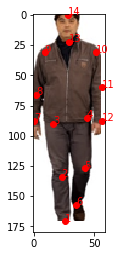

In [7]:
print(image_crop.shape)

plt.imshow(image_crop[:,:,::-1])
plotJoint(joints_crop)
plt.show()

(227, 227, 3)


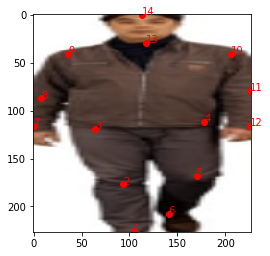

In [8]:
# reshape 
import cv2 as cv

def apply_zoom(image, joints, fx, fy):
    assert fx is not None and fy is not None
    # TODO: cubic interpolation?
    zoomed_image = cv.resize(image, None, fx=fx, fy=fy)
    zoomed_joints = joints * np.array([fx, fy])
    zoomed_joints[:, 0] = np.clip(zoomed_joints[:, 0], 0, zoomed_image.shape[1] - 1)
    zoomed_joints[:, 1] = np.clip(zoomed_joints[:, 1], 0, zoomed_image.shape[0] - 1)
    return zoomed_image, zoomed_joints.astype(np.int32)
    
def crop_reshape(image, joints, bbox, im_size=227):
    joints = np.array(joints)
    x_min, y_min, w, h = bbox
    image = image[y_min:y_min + h, x_min:x_min + w]
    assert y_min == 0
    assert x_min == 0
    joints_reshape = joints - np.array([x_min, y_min])
    assert image.shape[:2] == (h, w)

    fx, fy = im_size / w, im_size / h
    image_reshape, joints_reshape = apply_zoom(image, joints, fx, fy)
    bbox_reshape = np.array([0, 0, image_reshape.shape[1], image_reshape.shape[0]], dtype=int)
    return image_reshape, joints_reshape, bbox_reshape

image_reshape, joints_reshape, bbox_reshape = crop_reshape(image_crop, joints_crop, bbox_crop)

print(image_reshape.shape)

plt.imshow(image_reshape[:,:,::-1])
plotJoint(joints_reshape)
plt.show()

In [9]:
## TODO

In [10]:
# load creat regressionnet and load weight from snapshot 

from scripts import regressionnet

snapshot_path = '/var/data/out/lsp_alexnet_imagenet/checkpoint-1000000'

net, loss_op, pose_loss_op, train_op = regressionnet.create_regression_net(
    n_joints=numJoints,
    init_snapshot_path=snapshot_path,
    is_resume=True,
    net_type='Alexnet',
    optimizer_type='momentum',
    gpu_memory_fraction=0.32)  # Set how much GPU memory to reserve for the network

print(net)
print(snapshot_path)

/home/yyoo/tf3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Alexnet::__create_architecture()
Initializing conv1 with random
Initializing conv2 with random
Initializing conv3 with random
Initializing conv4 with random
Initializing conv5 with random
Initializing fc6 with random
Initializing fc7 with random
Initializing fc8 with random
Initializing layer 99 with random
Restoring everything from snapshot and resuming from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000
INFO:tensorflow:Restoring parameters from /var/data/out/lsp_alexnet_imagenet/checkpoint-1000000
Creating optimizer momentum
Conv LR: Tensor("lr/conv_lr:0", shape=(), dtype=float32), FC LR: Tensor("lr/fc_lr:0", shape=(), dtype=float32)
INFO:tensorflow:Summary name grad_norms/conv1/weight:0 is illegal; using grad_norms/conv1/weight_0 instead.
INFO:tensorflow:Summary name grad_norms/conv1/bias:0 is illegal; using grad_norms/conv1/bias_0 instead.
INFO:tensorflow:Summary name grad_norms/conv2/weight:0 is illegal; using grad_norms/conv2/weight_0 instead.
INFO:tensorflow:Summary name 

In [26]:
## estimate pose using the trained model
#avg_loss, global_step, gt_joints, gt_joints_is_valid, predicted_joints, orig_bboxes = scripts.regressionnet.predict(net, pose_loss_op, test_dataset, batch_size, summary_writer=None, dataset_name=dataset_name, tag_prefix='test')


conv_lr=0.0
fc_lr=0.0
#phase='test'
is_phase_train=False
keep_prob=1.0

feed_dict = {
        net.x: image_reshape.reshape(1,227,227,3),
        'pose_input/joints_gt:0': joints_reshape.reshape(1,14,2),
        'pose_input/joints_is_valid:0': joints_valid.reshape(1,14,2),
        'input/is_phase_train:0': is_phase_train,
        'lr/conv_lr:0': conv_lr,
        'lr/fc_lr:0': fc_lr,
        'fc6/keep_prob_pl:0': keep_prob,
        'fc7/keep_prob_pl:0': keep_prob
}


joints_pred, batch_loss_value = net.sess.run([net.fc_regression, pose_loss_op], feed_dict=feed_dict)
    

In [33]:
#joints_pred.shape
joints_pred=joints_pred.reshape(14,2)
print(joints_pred)

[[ 0.08091423 -0.27261072]
 [-0.00582319 -0.21567777]
 [-0.11389025 -0.13537948]
 [ 0.1182666  -0.12821524]
 [ 0.11299161 -0.14474073]
 [ 0.06836522 -0.16917594]
 [ 0.03014952 -0.05477847]
 [-0.11845146 -0.02626668]
 [-0.08792227  0.07211979]
 [ 0.1373331   0.02221456]
 [ 0.10512796 -0.05038304]
 [ 0.22762305 -0.04601182]
 [ 0.01953563  0.06732343]
 [ 0.05610312  0.14734073]]


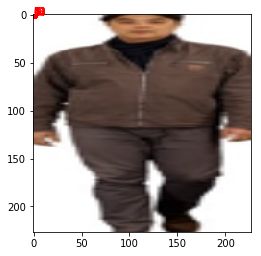

In [34]:
plt.imshow(image_reshape[:,:,::-1])
plotJoint(joints_pred)
plt.show()

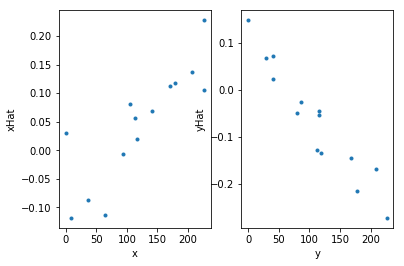

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline

x = joints_reshape[:,0]
xhat = joints_pred[:,0]
y = joints_reshape[:,1]
yhat = joints_pred[:,1]


plt.subplot(121)
plt.plot(x,xhat,'.')
plt.xlabel('x');plt.ylabel('xHat');
#plt.plot([min(x), max(x)], [min(x), max(x)],'--')
plt.subplot(122)
plt.plot(y,yhat,'.')
#plt.plot([min(y), max(y)], [min(y), max(y)],'--')
plt.xlabel('y');plt.ylabel('yHat');

In [ ]:
## TO DO: SCALE BACK!